# Risk forecasting DNN model

In [1]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

In [3]:
SERIES_PERIOD = '10y'
SERIES_INTERVAL = '1d'
LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = 0.9
EPOCHS = 10
BATCH_SIZE = 32

### Dataset

In [4]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# fetch VIX volatility data
vix = '^VIX'
vix_data = yf.Ticker(vix)
vix_history = vix_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
vix_close = vix_history.Close.loc[vix_history.Close != 0][:-1]

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'close': close,
    'returns': (log_returns - log_returns.mean()) / log_returns.std(),
    'vix': (vix_close - vix_close.mean()) / vix_close.std(),
    'volatility': (volatility - volatility.mean()) / volatility.std()
})
X.dropna(inplace=True)
X

,close,returns,vix,volatility
Date,,,,
2012-06-11,1308.930054,-1.231793,0.872357,0.664908
2012-06-12,1324.180054,1.039295,0.664860,0.715954
2012-06-13,1314.880005,-0.703166,0.972577,0.270656
2012-06-14,1329.099976,0.961971,0.606986,0.421980
2012-06-15,1342.839966,0.917842,0.526528,0.468211
...,...,...,...,...
2022-05-26,4057.840088,1.797276,1.428507,0.531248
2022-05-27,4158.240234,2.241786,1.177252,0.668043
2022-05-31,4132.149902,-0.632659,1.243595,0.932627


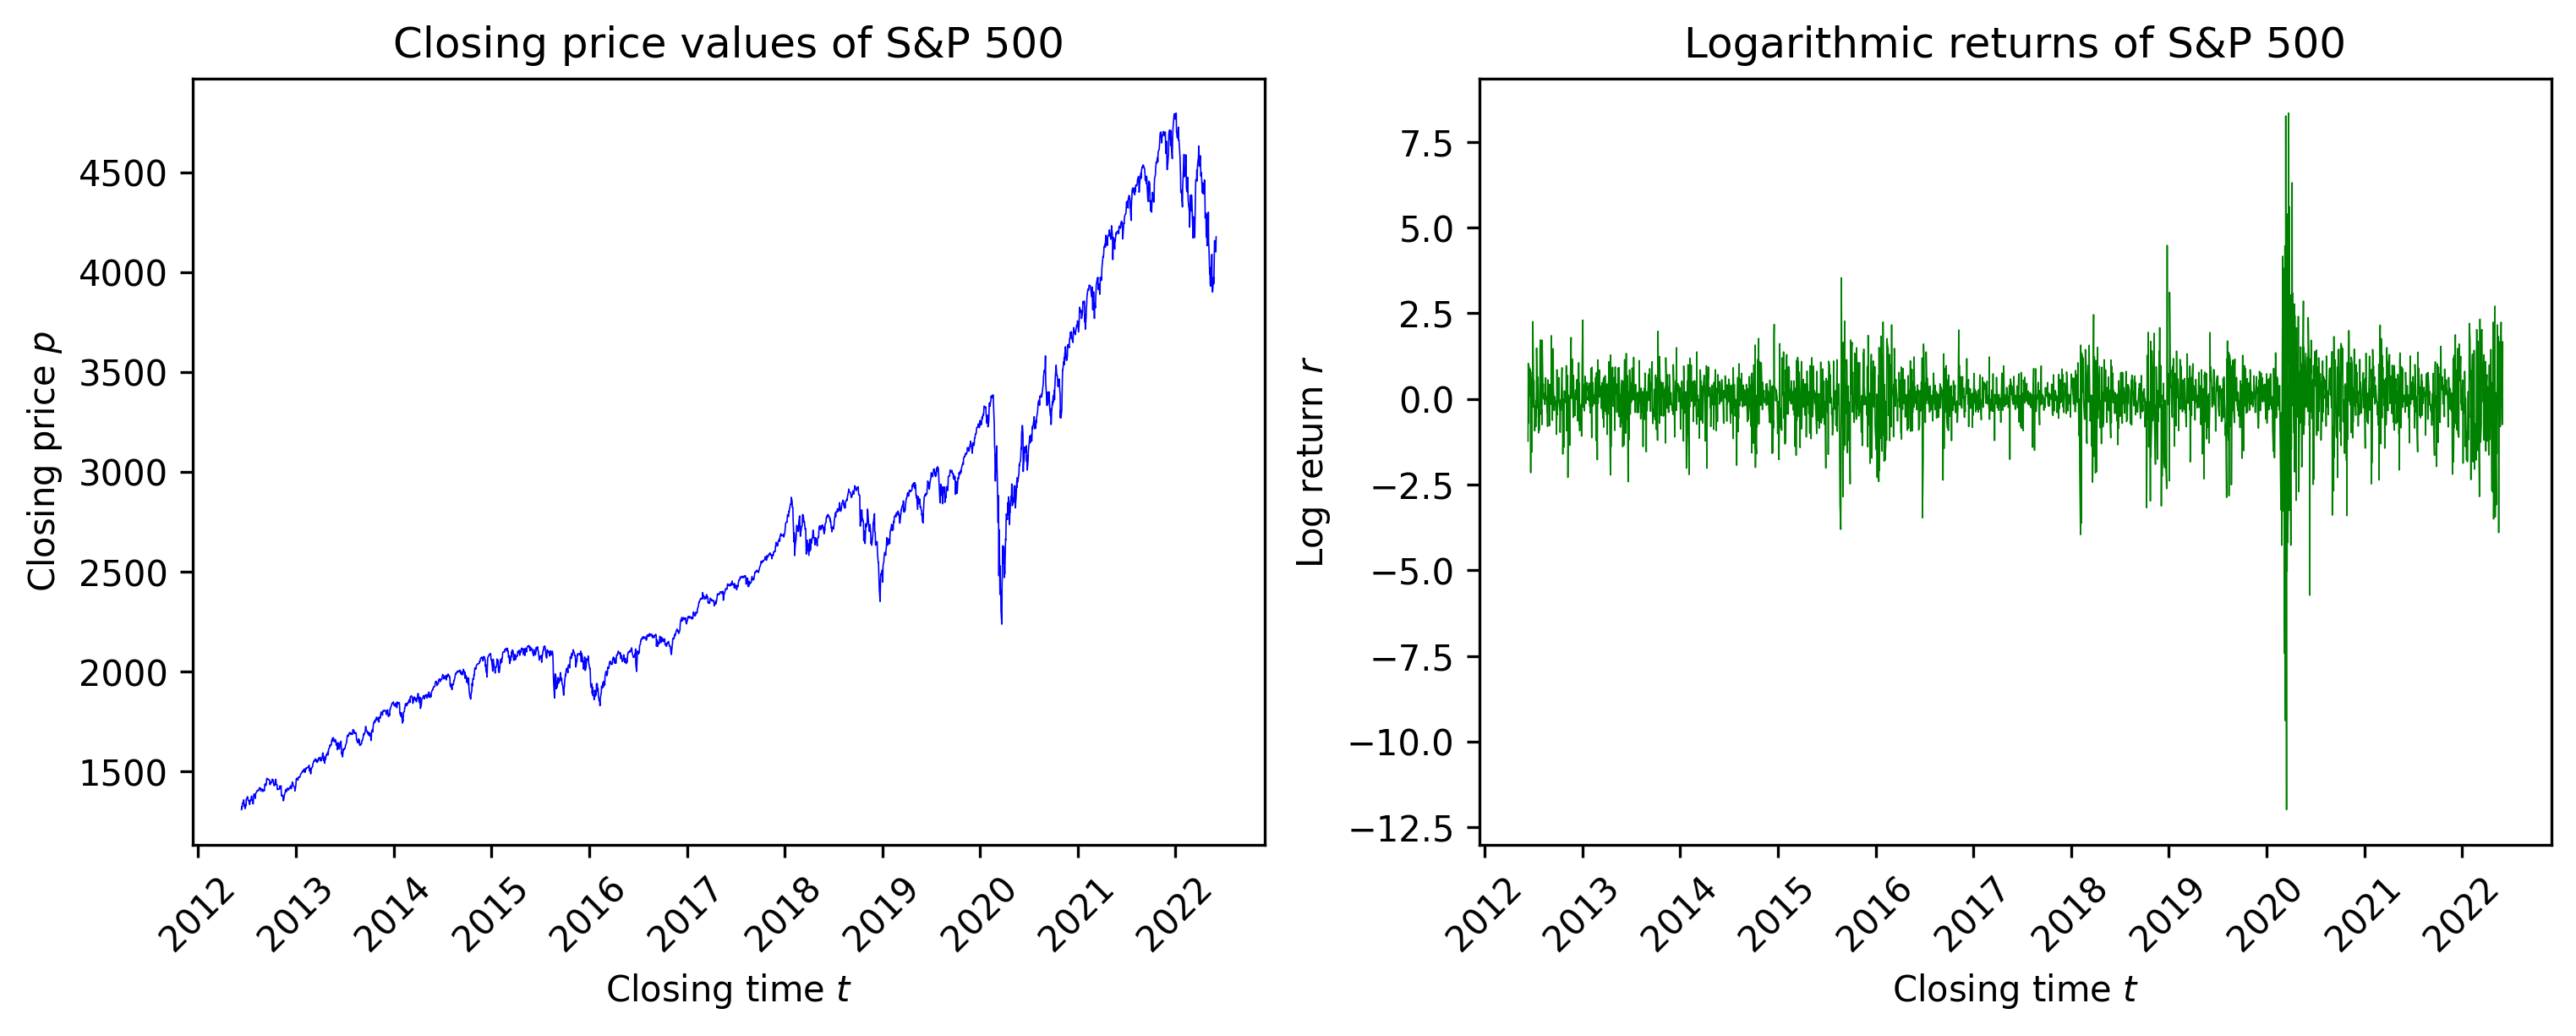

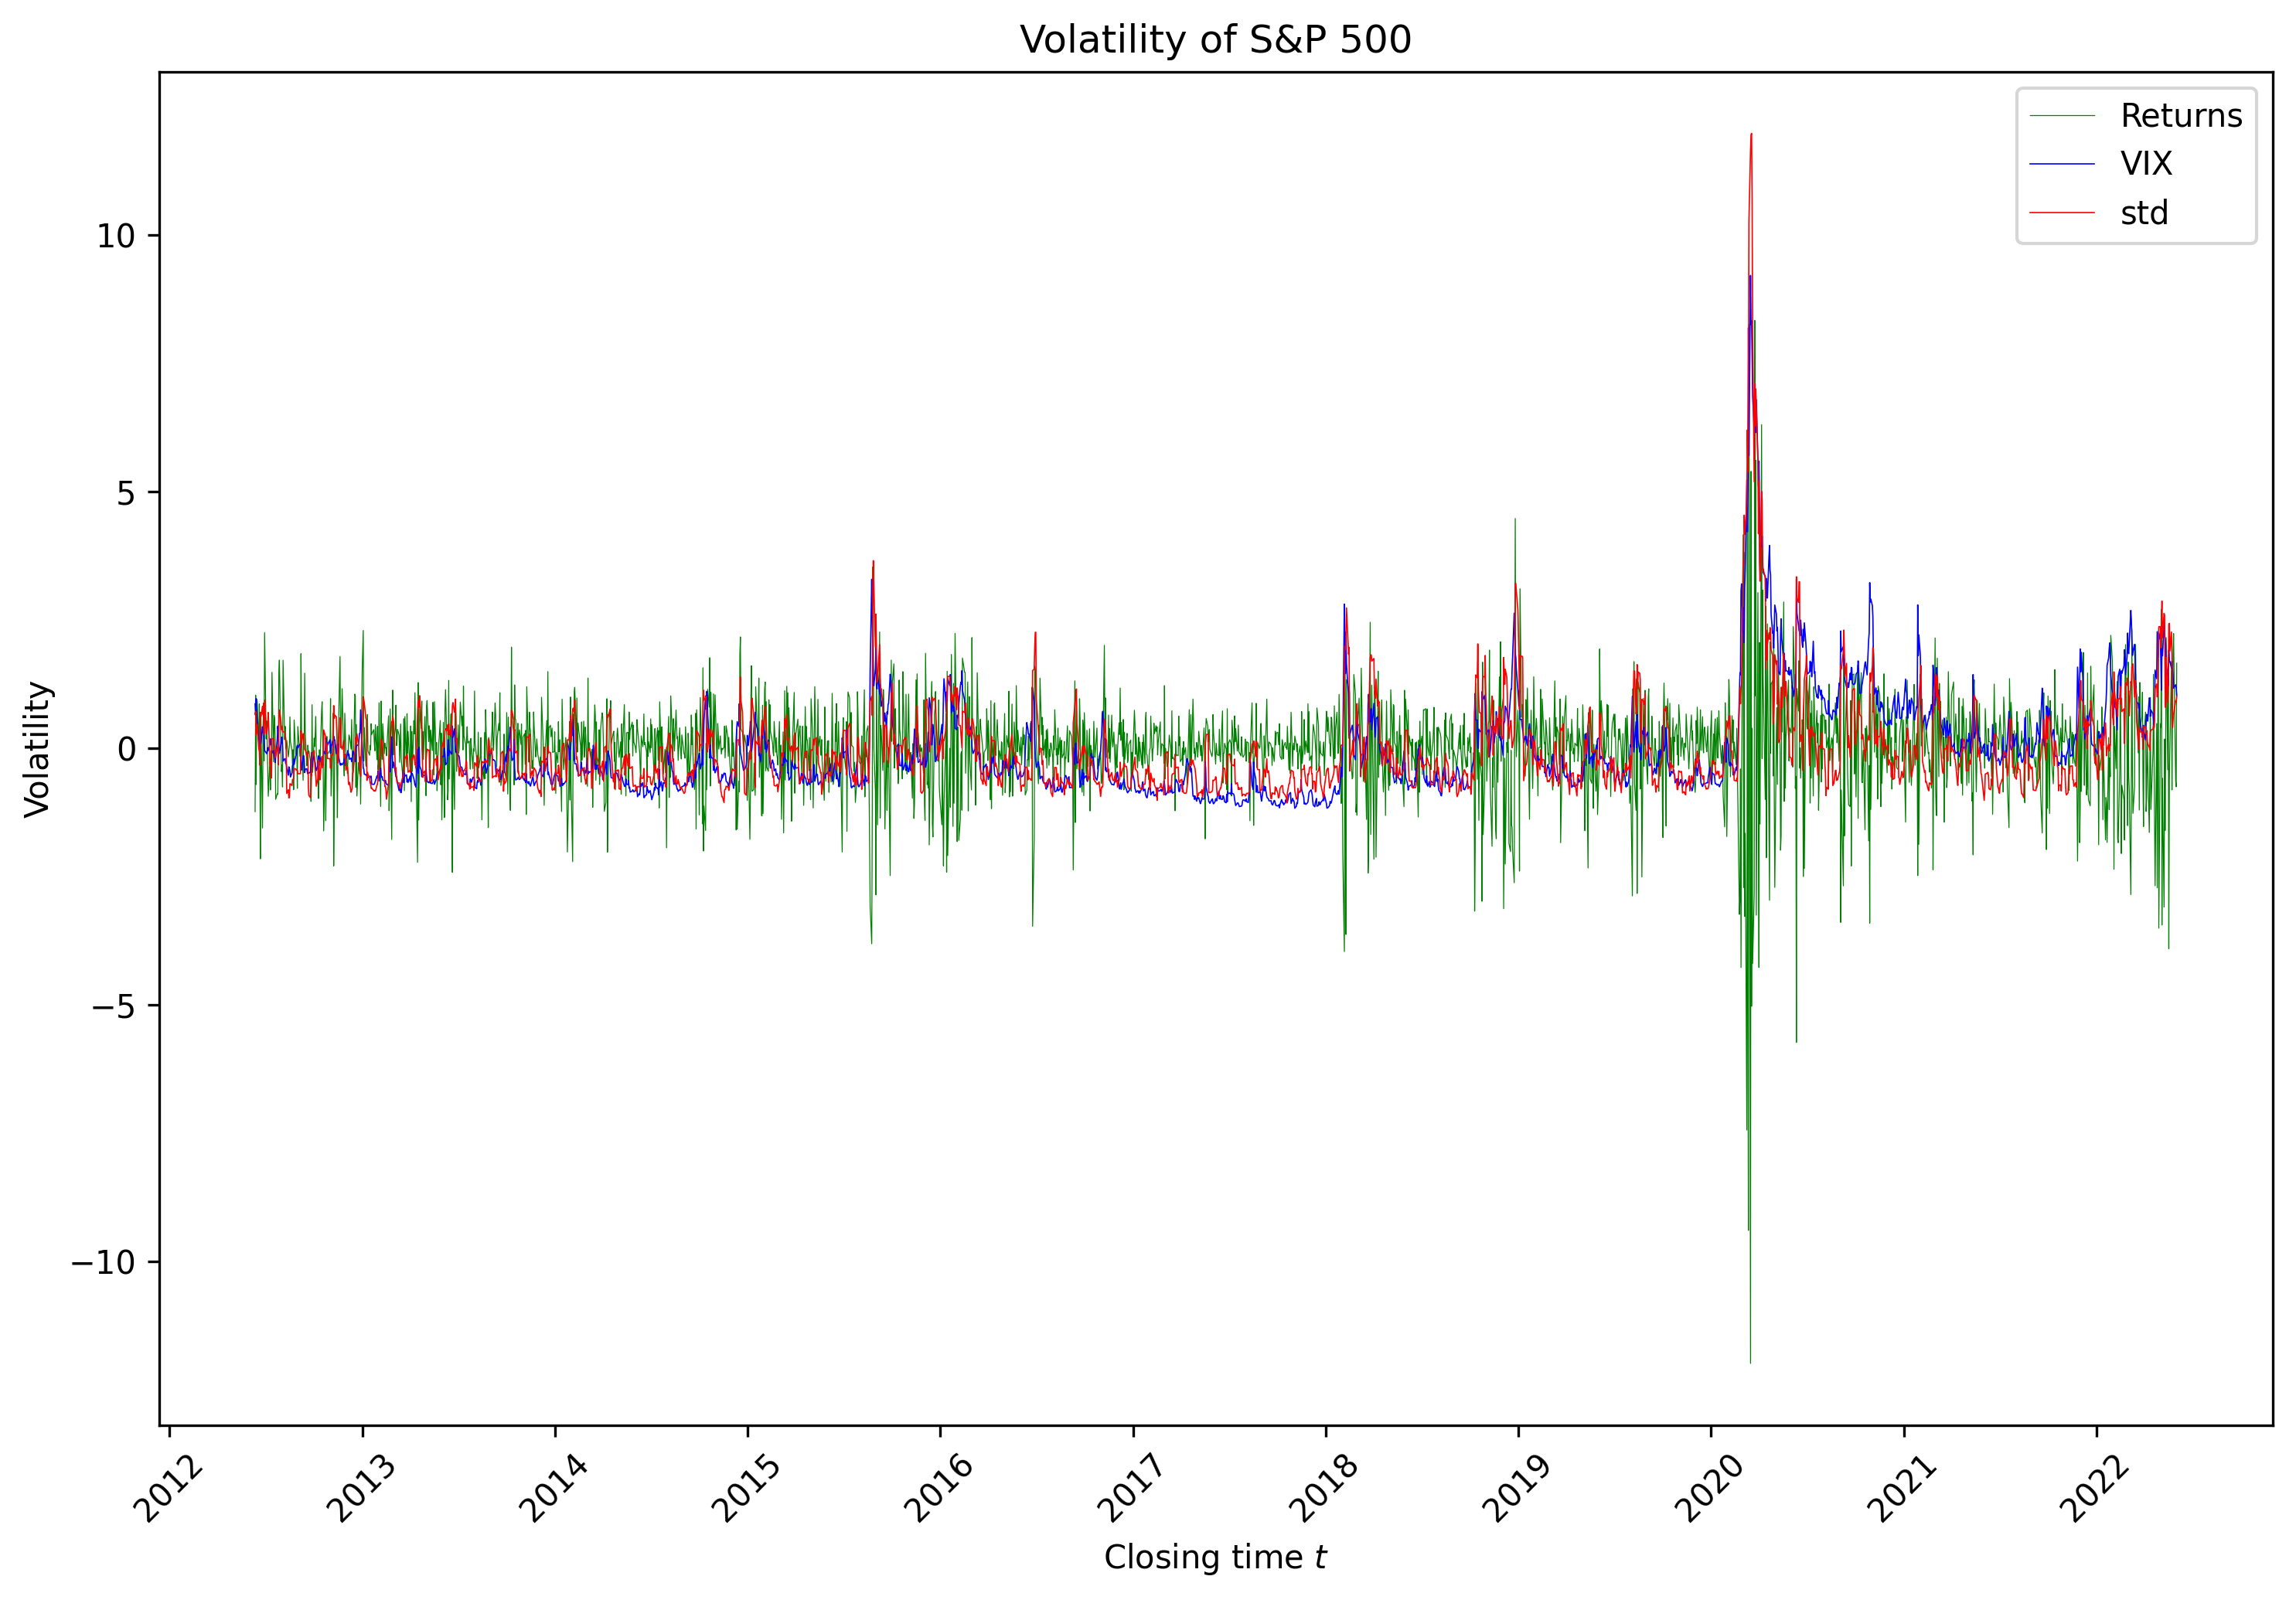

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

ax[0].plot(X.close, linewidth=0.4, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.4, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=300)
ax.plot(X.returns, linewidth=0.3, color='g', label='Returns')
ax.plot(X.vix, linewidth=0.4, color='b', label='VIX')
ax.plot(X.volatility, linewidth=0.4, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
# build instances X as sequence of `LOOKBACK_WINDOW` vix values, and labels y as subsequent vix value
version = 'univariate'

X_data = []
y_data = []

if version == 'univariate':

    print("Univariate data")

    for i in range(X.vix.shape[0] - LOOKBACK_WINDOW):
        X_data.append(X.vix[i: i + LOOKBACK_WINDOW])
        y_data.append(X.vix[i + LOOKBACK_WINDOW])

    X_data = np.array(X_data)
    X_data = np.expand_dims(X_data, 2)
    y_data = np.array(y_data)
    y_data = np.expand_dims(y_data, 1)

elif version == 'multivariate':

    print("Multivariate data")

    X_mat = X.drop(['vix'], axis=1).values
    transformer = Normalizer().fit(X_mat)
    X_mat = transformer.transform(X_mat)
    y_vec = np.expand_dims(X.vix.values, 1)

    for i in range(X_mat.shape[0] - LOOKBACK_WINDOW):
        X_data.append(
            np.hstack(
                (X_mat[i: i + LOOKBACK_WINDOW], y_vec[i: i + LOOKBACK_WINDOW])
            )
        )

        y_data.append(y_vec[i + LOOKBACK_WINDOW])

    X_data = np.array(X_data)
    y_data = np.array(y_data)

else:
    exit(1)

print(X_data.shape, y_data.shape)

Univariate data
(2502, 10, 1) (2502, 1)


In [7]:
# split into training and testing data
train_test_split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:train_test_split]
y_train = y_data[:train_test_split]

X_test = X_data[train_test_split:]
y_test = y_data[train_test_split:]

# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=(1 - TRAIN_TEST_SPLIT), shuffle=False)

print(X_train.shape, y_train.shape, '\n', X_test.shape, y_test.shape)

(2251, 10, 1) (2251, 1) 
 (251, 10, 1) (251, 1)


In [8]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

rnn_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
gru_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
lstm_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
bidir_model.compile(loss='mae', optimizer='adam', metrics=['mse'])

In [9]:
rnn_history = rnn_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
gru_history = gru_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
lstm_history = lstm_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)
bidir_history = bidir_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
71/71 [==============================] - 3s 23ms/step - loss: 0.3537 - mse: 0.4623
Epoch 2/10
71/71 [==============================] - 2s 23ms/step - loss: 0.1573 - mse: 0.0842
Epoch 3/10
71/71 [==============================] - 2s 23ms/step - loss: 0.1563 - mse: 0.0822
Epoch 4/10
71/71 [==============================] - 2s 23ms/step - loss: 0.1601 - mse: 0.0865
Epoch 5/10
71/71 [==============================] - 2s 23ms/step - loss: 0.1664 - mse: 0.0853
Epoch 6/10
71/71 [==============================] - 2s 22ms/step - loss: 0.1588 - mse: 0.0798
Epoch 7/10
71/71 [==============================] - 2s 22ms/step - loss: 0.1523 - mse: 0.0788
Epoch 8/10
71/71 [==============================] - 2s 22ms/step - loss: 0.1504 - mse: 0.0727
Epoch 9/10
71/71 [==============================] - 2s 22ms/step - loss: 0.1616 - mse: 0.0833
Epoch 10/10
71/71 [==============================] - 2s 22ms/step - loss: 0.1550 - mse: 0.0765
Epoch 1/10
71/71 [==============================] - 4s 6ms/

MSE:
    - RNN: 0.0856527771994682
    - GRU: 0.08658109749655098
    - LSTM: 0.08530951115937672
    - Bidirectional LSTM: 0.08477429127247427


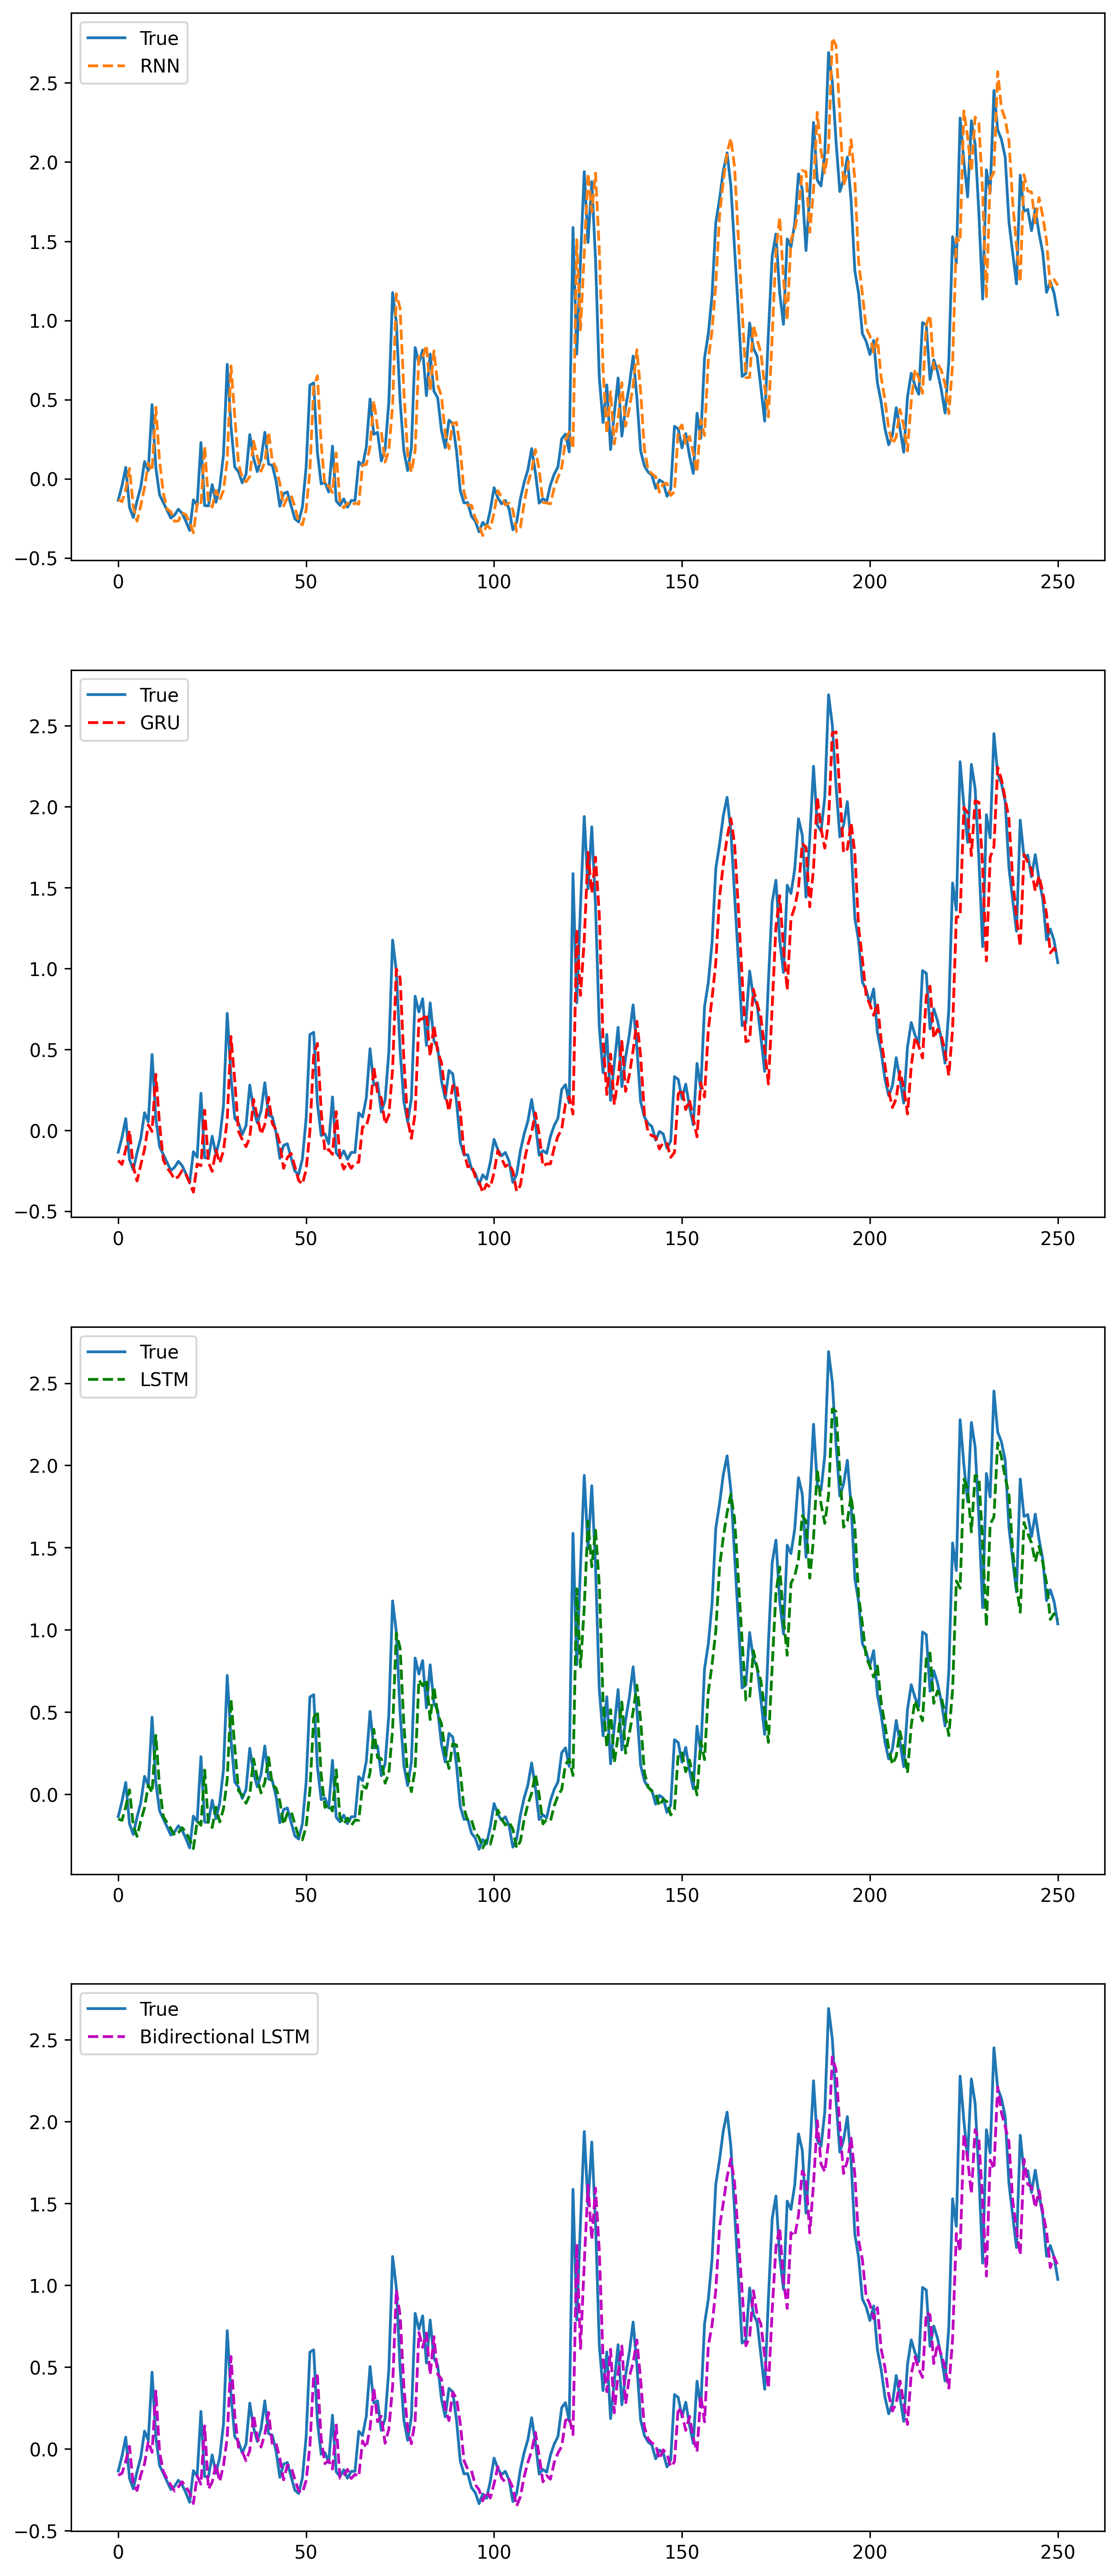

In [10]:
print("MSE:")
rnn_pred = rnn_model.predict(X_test)
rnn_mse = np.square(np.subtract(y_test, rnn_pred)).mean()
print(f"    - RNN: {rnn_mse}")

gru_pred = gru_model.predict(X_test)
gru_mse = np.square(np.subtract(y_test, gru_pred)).mean()
print(f"    - GRU: {gru_mse}")

lstm_pred = lstm_model.predict(X_test)
lstm_mse = np.square(np.subtract(y_test, lstm_pred)).mean()
print(f"    - LSTM: {lstm_mse}")

bidir_pred = bidir_model.predict(X_test)
bidir_mse = np.square(np.subtract(y_test, bidir_pred)).mean()
print(f"    - Bidirectional LSTM: {bidir_mse}")

fig, ax = plt.subplots(4, 1, figsize=(10, 25), dpi=300)

ax[0].plot(y_test, label='True')
ax[0].plot(rnn_pred, linestyle='--', label='RNN')
ax[0].legend(loc=2)

ax[1].plot(y_test, label='True')
ax[1].plot(gru_pred, linestyle='--', color='r', label='GRU')
ax[1].legend(loc=2)

ax[2].plot(y_test, label='True')
ax[2].plot(lstm_pred, linestyle='--', color='g', label='LSTM')
ax[2].legend(loc=2)

ax[3].plot(y_test, label='True')
ax[3].plot(bidir_pred, linestyle='--', color='m', label='Bidirectional LSTM')
ax[3].legend(loc=2)

plt.show()

**MSE**

*Univariate:*

- RNN: 0.08593333209299565
- GRU: 0.08628534089919165
- LSTM: 0.08416588001742062
- Bidirectional LSTM: 0.08573480099843421

*Multivariate:*

- RNN: 0.08878069443231994
- GRU: 0.08174636626249593
- LSTM: 0.0817325979890831
- Bidirectional LSTM: 0.08251407624835211